# Installing and Importing Libraries

In [1]:
!pip install librosa
!pip install tensorflow

In [2]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
import librosa.display
import os

import sklearn
from sklearn.preprocessing import LabelEncoder, StandardScaler, minmax_scale
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, log_loss

import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

from scipy.stats import loguniform, randint


with warnings.catch_warnings():
    warnings.simplefilter("ignore")

sns.set(style="whitegrid")

%matplotlib inline

# Downloading and Extracting Audio Data

In [3]:
!wget https://www.dropbox.com/s/4jw31k5mlzcmgis/genres.tar.gz?dl=0

--2025-02-13 08:21:56--  https://www.dropbox.com/s/4jw31k5mlzcmgis/genres.tar.gz?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.65.18, 2620:100:6021:18::a27d:4112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.65.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.dropbox.com/scl/fi/logv7hsjc1t3daaysuhyh/genres.tar.gz?rlkey=vcu3jvliyletkjwxz8bv8jm7c&dl=0 [following]
--2025-02-13 08:21:56--  https://www.dropbox.com/scl/fi/logv7hsjc1t3daaysuhyh/genres.tar.gz?rlkey=vcu3jvliyletkjwxz8bv8jm7c&dl=0
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucf472d4bf524426dd43e4322be8.dl.dropboxusercontent.com/cd/0/inline/CkBZMrbVcMdMtOMrHKD2UCEE2_3Pa2fkHeoKHJUyFwsq4UK25Uiek2j6D7gT0AgxdT7RgycI8nWNBihDBFbkYDD0v-Mw_olw65AcMu-Zp_LyoWftcmhco8zBMaFI3JA7zOQ/file# [following]
--2025-02-13 08:21:56--  https://ucf472d4bf524426dd43e4322be8.dl.dropboxusercontent.com/cd/0/inline/C

In [4]:
!tar -xzvf /content/genres.tar.gz?dl=0

genres/
genres/blues/
genres/blues/blues.00000.au
genres/blues/blues.00001.au
genres/blues/blues.00002.au
genres/blues/blues.00003.au
genres/blues/blues.00004.au
genres/blues/blues.00005.au
genres/blues/blues.00006.au
genres/blues/blues.00007.au
genres/blues/blues.00008.au
genres/blues/blues.00009.au
genres/blues/blues.00010.au
genres/blues/blues.00011.au
genres/blues/blues.00012.au
genres/blues/blues.00013.au
genres/blues/blues.00014.au
genres/blues/blues.00015.au
genres/blues/blues.00016.au
genres/blues/blues.00017.au
genres/blues/blues.00018.au
genres/blues/blues.00019.au
genres/blues/blues.00020.au
genres/blues/blues.00021.au
genres/blues/blues.00022.au
genres/blues/blues.00023.au
genres/blues/blues.00024.au
genres/blues/blues.00025.au
genres/blues/blues.00026.au
genres/blues/blues.00027.au
genres/blues/blues.00028.au
genres/blues/blues.00029.au
genres/blues/blues.00030.au
genres/blues/blues.00031.au
genres/blues/blues.00032.au
genres/blues/blues.00033.au
genres/blues/blues.00034.a

In [5]:
audio_path = '/content/genres/blues/blues.00043.au'
audio, sr = librosa.load(audio_path)

# Visualizing the Audio Waveform

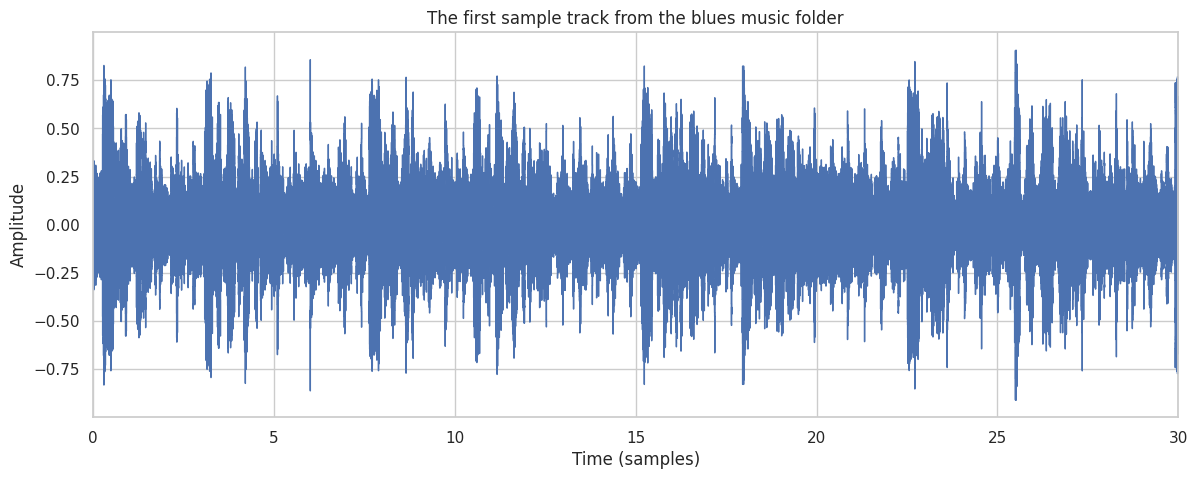

In [6]:
plt.figure(figsize=(14, 5))
librosa.display.waveshow(audio, sr=sr)
plt.xlabel('Time (samples)')
plt.ylabel('Amplitude')
plt.title('The first sample track from the blues music folder')
plt.xlim([0,30])
plt.show()

# Extracting and Visualizing Chroma Features

 Captured pitch class information to analyze harmonic and melodic content.

In [7]:
chroma_stft = librosa.feature.chroma_stft(y=audio, sr=sr)

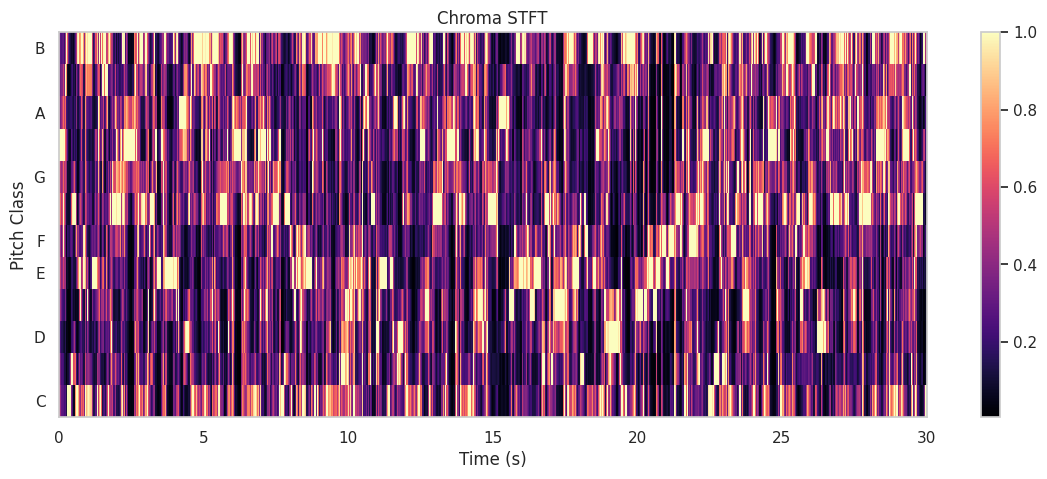

In [8]:
plt.figure(figsize=(14, 5))
librosa.display.specshow(chroma_stft, x_axis='time', y_axis='chroma', sr=sr)
plt.colorbar()
plt.xlabel('Time (s)')
plt.ylabel('Pitch Class')
plt.title('Chroma STFT')
plt.show()

# Extracting Root Mean Square (RMS) Energy

Measures the average energy (loudness) of the audio signal.

In [9]:
rms = librosa.feature.rms(y=audio)
rms_mean = rms.mean()

In [10]:
rms_mean

0.12730543

# Spectral Centroid

Indicates the center of mass (brightness) of the spectrum.

In [11]:
spectral_centroids = librosa.feature.spectral_centroid(y=audio, sr=sr)

In [12]:
spectral_centroids_mean = spectral_centroids.mean()

In [13]:
spectral_centroids_mean

2155.845202161907

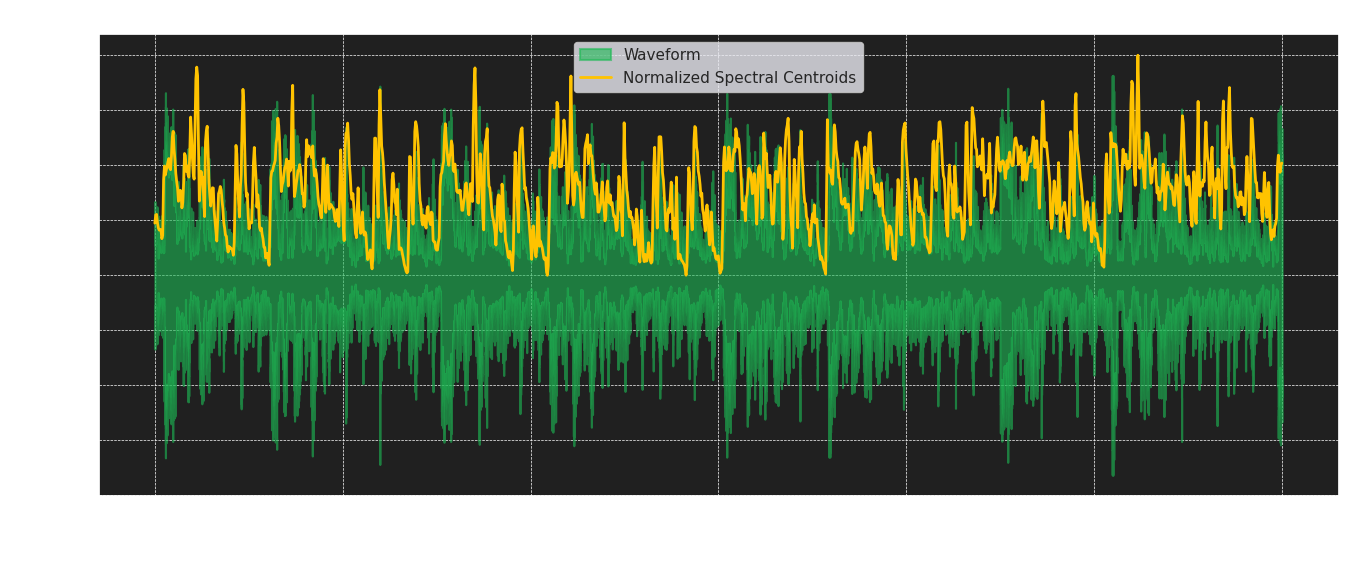

In [14]:
# Computing the time variable for visualization
frames = range(len(spectral_centroids[0]))
t = librosa.frames_to_time(frames, sr=sr)

# Function that normalizes the Sound Data
def normalize(x, axis=0):
    return minmax_scale(x, axis=axis)

# Use a stylish plot theme
sns.set_theme(style="darkgrid")

# Plotting the Spectral Centroid along the waveform
plt.figure(figsize=(16, 6))
ax = plt.axes()
ax.set_facecolor('#202020')  # Set a dark background color

# Waveform plot
librosa.display.waveshow(audio, sr=sr, alpha=0.6, color='#1DB954', linewidth=1.5, label='Waveform')

# Spectral centroids plot
plt.plot(t, normalize(spectral_centroids[0]), color='#FFC300', linewidth=2, label='Normalized Spectral Centroids')

# Enhancing the plot
plt.title('Waveform and Normalized Spectral Centroids', fontsize=16, fontweight='bold', color='white')
plt.xlabel('Time (seconds)', fontsize=14, color='white')
plt.ylabel('Normalized Amplitude / Frequency', fontsize=14, color='white')
plt.legend()
plt.grid(True, linestyle='--', linewidth=0.5)
plt.xticks(fontsize=12, color='white')
plt.yticks(fontsize=12, color='white')

# Show the plot
plt.show()

# Spectral Bandwidth Mean

Represents the spread of frequencies around the centroid.

In [14]:
spectral_bandwidths = librosa.feature.spectral_bandwidth(y=audio, sr=sr)

In [15]:
spectral_bandwidths_mean = spectral_bandwidths.mean()

In [16]:
spectral_bandwidths_mean

2371.9955858441676

# Spectral Rolloff

Frequency below which a certain percentage (e.g., 85%) of spectral energy is contained.

In [17]:
spectral_rolloff = librosa.feature.spectral_rolloff(y=audio, sr=sr)

In [18]:
spectral_rolloff_mean = spectral_rolloff.mean()

In [19]:
spectral_rolloff_mean

5011.532444079901

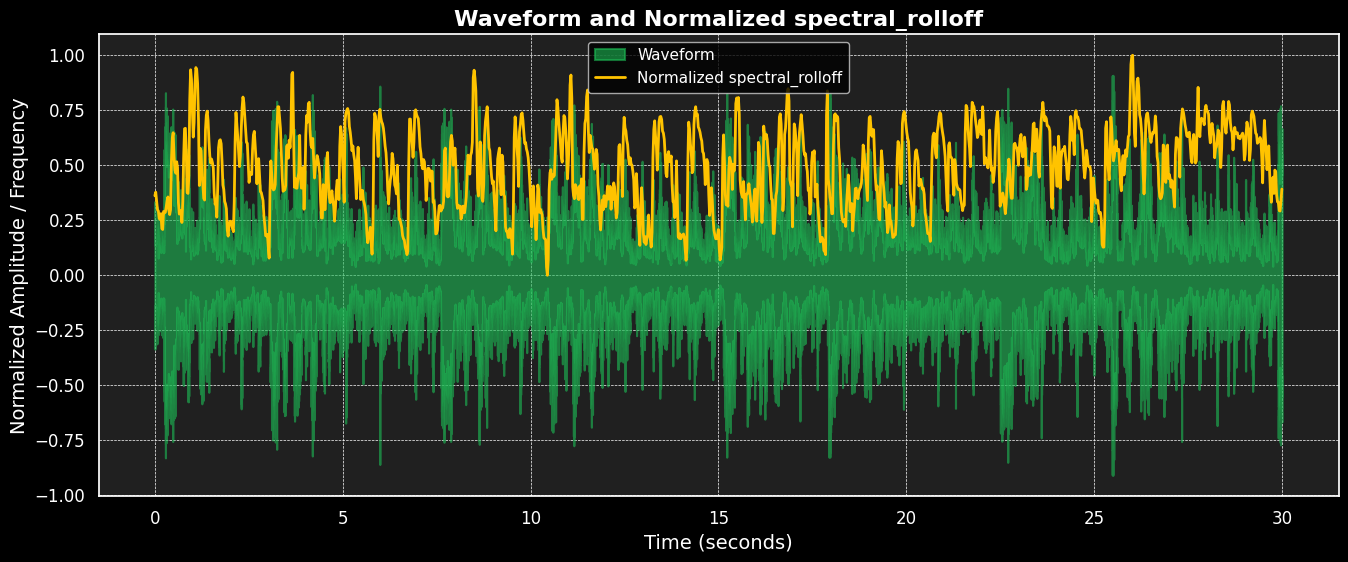

In [20]:
# Computing the time variable for visualization
frames = range(len(spectral_rolloff [0]))
t = librosa.frames_to_time(frames, sr=sr)

# Function that normalizes the Sound Data
def normalize(x, axis=0):
    return minmax_scale(x, axis=axis)

# Use a stylish plot theme
plt.style.use(style = 'dark_background')

# Plotting the spectral_rolloff along the waveform
plt.figure(figsize=(16, 6))
ax = plt.axes()
ax.set_facecolor('#202020')  # Set a dark background color

# Waveform plot
librosa.display.waveshow(audio, sr=sr, alpha=0.6, color='#1DB954', linewidth=1.5, label='Waveform')

# chroma_cens plot
plt.plot(t, normalize(spectral_rolloff[0]), color='#FFC300', linewidth=2, label='Normalized spectral_rolloff')

# Enhancing the plot
plt.title('Waveform and Normalized spectral_rolloff', fontsize=16, fontweight='bold', color='white')
plt.xlabel('Time (seconds)', fontsize=14, color='white')
plt.ylabel('Normalized Amplitude / Frequency', fontsize=14, color='white')
plt.legend()
plt.grid(True, linestyle='--', linewidth=0.5)
plt.xticks(fontsize=12, color='white')
plt.yticks(fontsize=12, color='white')

# Show the plot
plt.show()

# Zero-Crossing Rate

Measures the rate at which the signal crosses zero amplitude (useful for detecting percussive sounds).

In [21]:
zero_crossing_rates = librosa.feature.zero_crossing_rate(y=audio)

In [22]:
zero_crossing_rates_mean = zero_crossing_rates.mean()

In [23]:
zero_crossing_rates_mean

0.08717463022041763

# Harmony (Chroma CENS)

Captures harmonic content with temporal smoothing, emphasizing chroma features.

In [24]:
chroma_cens = librosa.feature.chroma_cens(y=audio, sr=sr)

In [25]:
harmony_mean = chroma_cens.mean()

In [26]:
harmony_mean

0.27466014

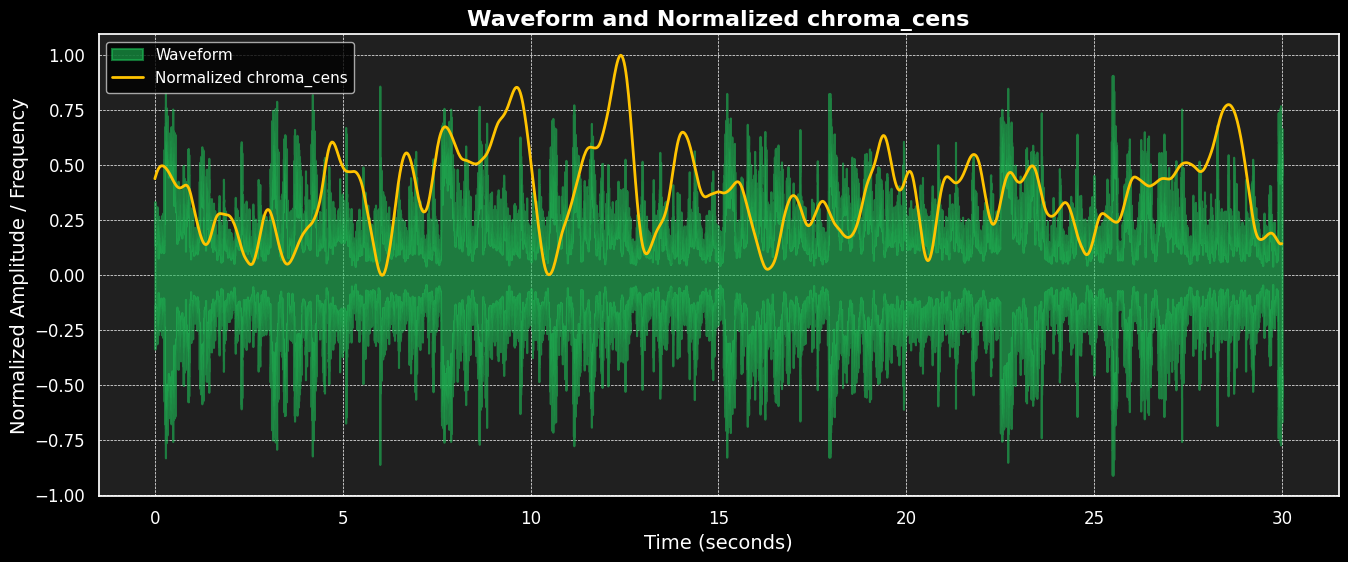

In [27]:
# Computing the time variable for visualization
frames = range(len(chroma_cens[0]))
t = librosa.frames_to_time(frames, sr=sr)

# Function that normalizes the Sound Data
def normalize(x, axis=0):
    return minmax_scale(x, axis=axis)

# Use a stylish plot theme
plt.style.use(style = 'dark_background')

# Plotting the Spectral Centroid along the waveform
plt.figure(figsize=(16, 6))
ax = plt.axes()
ax.set_facecolor('#202020')  # Set a dark background color

# Waveform plot
librosa.display.waveshow(audio, sr=sr, alpha=0.6, color='#1DB954', linewidth=1.5, label='Waveform')

# chroma_cens plot
plt.plot(t, normalize(chroma_cens[0]), color='#FFC300', linewidth=2, label='Normalized chroma_cens')

# Enhancing the plot
plt.title('Waveform and Normalized chroma_cens', fontsize=16, fontweight='bold', color='white')
plt.xlabel('Time (seconds)', fontsize=14, color='white')
plt.ylabel('Normalized Amplitude / Frequency', fontsize=14, color='white')
plt.legend()
plt.grid(True, linestyle='--', linewidth=0.5)
plt.xticks(fontsize=12, color='white')
plt.yticks(fontsize=12, color='white')

# Show the plot
plt.show()

# Tempo Mean (BPM)

Estimates the tempo (beats per minute) of the audio track, representing rhythm speed.

In [28]:
tempo, _ = librosa.beat.beat_track(y=audio, sr=sr)

In [29]:
tempo_mean = tempo.mean()

In [30]:
tempo_mean

129.19921875

# Compute MFCCs

Captures the timbral characteristics of sound by representing short-term power spectrum based on human hearing perception. Often used in speech and music analysis.

In [31]:
# Compute MFCCs
mfccs = librosa.feature.mfcc(y=audio, sr=sr)

In [32]:
# Apply Feature Scaling
mfccs = sklearn.preprocessing.scale(mfccs, axis=1)

/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_data.py:258: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_data.py:277: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(


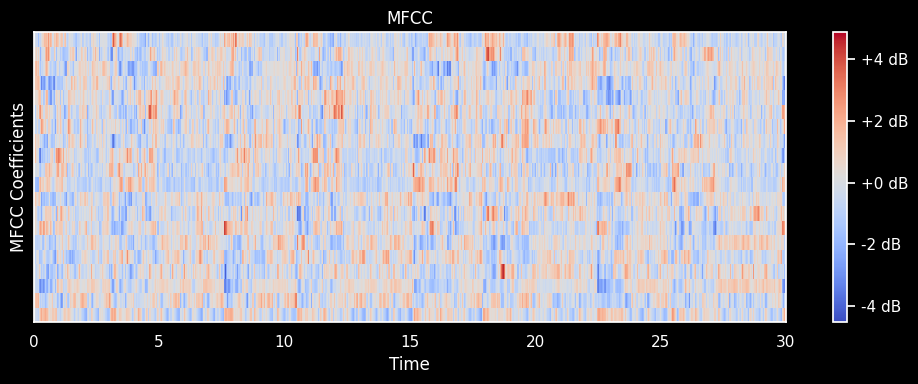

In [33]:
# Plot MFCCs
plt.figure(figsize=(10, 4))
librosa.display.specshow(mfccs, x_axis='time', cmap='coolwarm')
plt.colorbar(format='%+2.0f dB')
plt.title('MFCC')
plt.xlabel('Time')
plt.ylabel('MFCC Coefficients')
plt.tight_layout()
plt.show()

In [34]:
categories = ['blues', 'classical', 'country', 'disco', 'hiphop',
              'jazz', 'metal', 'pop', 'reggae', 'rock']

In [35]:
n_mfcc = 40
features = []
labels = []

In [36]:
audio_dataset_path = '/content/genres' # Change this line to the correct path of your dataset.
for category in categories:
    category_path = os.path.join(audio_dataset_path, category)  # Now, category_path is correct
    label = categories.index(category)

    for file_name in os.listdir(category_path):
        file_path = os.path.join(category_path, file_name)

        try:
            # Load audio file
            audio, sr = librosa.load(file_path, sr=None)

            # Extract features (e.g., MFCCs)
            mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc)
            mfccs_mean = np.mean(mfccs.T, axis=0)  # Take mean across time steps

            # Append features and labels
            features.append(mfccs_mean)
            labels.append(label)
        except Exception as e:
            print(f"Error processing file {file_path}: {e}")

# Convert to NumPy arrays

In [37]:
X = np.array(features)
y = np.array(labels)

# Split the data into training and testing sets

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Standardizing the features

In [39]:
scaler = StandardScaler()

In [40]:
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Decision Tree Classifier

In [41]:
dt_model = DecisionTreeClassifier(random_state=42)

In [42]:
dt_model.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

In [43]:
dt_preds = dt_model.predict_proba(X_test)

In [44]:
dt_loss = log_loss(y_test, dt_preds)
dt_accuracy = accuracy_score(y_test, dt_model.predict(X_test))

In [45]:
print(f"Decision Tree Loss: {dt_loss}")
print(f"Decision Tree Accuracy: {dt_accuracy}")

Decision Tree Loss: 18.922918029286503
Decision Tree Accuracy: 0.475


# Random Forest Classifier

In [46]:
rf_model = RandomForestClassifier(random_state=42)

In [47]:
rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [48]:
rf_preds = rf_model.predict_proba(X_test)

In [49]:
rf_loss = log_loss(y_test, rf_preds)
rf_accuracy = accuracy_score(y_test, rf_model.predict(X_test))

In [50]:
print(f"Random Forest Loss: {rf_loss}")
print(f"Random Forest Accuracy: {rf_accuracy}")

Random Forest Loss: 1.24274101786152
Random Forest Accuracy: 0.65


# Support Vector Machine Classifier

In [51]:
svm_model = SVC(probability=True, random_state=42)

In [52]:
svm_model.fit(X_train, y_train)

SVC(probability=True, random_state=42)

In [53]:
svm_preds = svm_model.predict_proba(X_test)

In [54]:
svm_loss = log_loss(y_test, svm_preds)
svm_accuracy = accuracy_score(y_test, svm_model.predict(X_test))

In [55]:
print(f"SVM Loss: {svm_loss}")
print(f"SVM Accuracy: {svm_accuracy}")

SVM Loss: 1.0112471315834062
SVM Accuracy: 0.655


# K-Nearest Neighbors Classifier

In [56]:
knn_model = KNeighborsClassifier()

In [57]:
knn_model.fit(X_train, y_train)

KNeighborsClassifier()

In [58]:
knn_preds = knn_model.predict_proba(X_test)

In [59]:
knn_loss = log_loss(y_test, knn_preds)
knn_accuracy = accuracy_score(y_test, knn_model.predict(X_test))

In [60]:
print(f"KNN Loss: {knn_loss}")
print(f"KNN Accuracy: {knn_accuracy}")

KNN Loss: 6.126521160432557
KNN Accuracy: 0.545


# Building a simple neural network model

In [61]:
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(len(np.unique(y)), activation='softmax')  # Adjust output layer for the number of genres
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


# Compiling the model

In [62]:
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Training the model

In [63]:
history = model.fit(X_train, y_train,
                    validation_split=0.2,
                    epochs=50,
                    batch_size=32,
                    verbose=1)

Epoch 1/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - accuracy: 0.0904 - loss: 2.5610 - val_accuracy: 0.2188 - val_loss: 2.1824
Epoch 2/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2043 - loss: 2.1375 - val_accuracy: 0.3500 - val_loss: 2.0092
Epoch 3/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3056 - loss: 1.9875 - val_accuracy: 0.3625 - val_loss: 1.8833
Epoch 4/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3702 - loss: 1.7996 - val_accuracy: 0.4000 - val_loss: 1.7836
Epoch 5/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4185 - loss: 1.7102 - val_accuracy: 0.4000 - val_loss: 1.6900
Epoch 6/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4624 - loss: 1.6326 - val_accuracy: 0.4187 - val_loss: 1.6260
Epoch 7/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4396 - loss: 1.5926 - val_accuracy: 0.4500 - val_loss: 1.5521
Epoch 8/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4450 - loss: 1.5465 - val_accuracy: 0.4563 - val_loss

# Evaluating the model

In [64]:
loss, accuracy = model.evaluate(X_test, y_test, verbose=1)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 0.6522 - loss: 1.0543
Test Loss: 1.1357593536376953
Test Accuracy: 0.6200000047683716


# Plotting training history

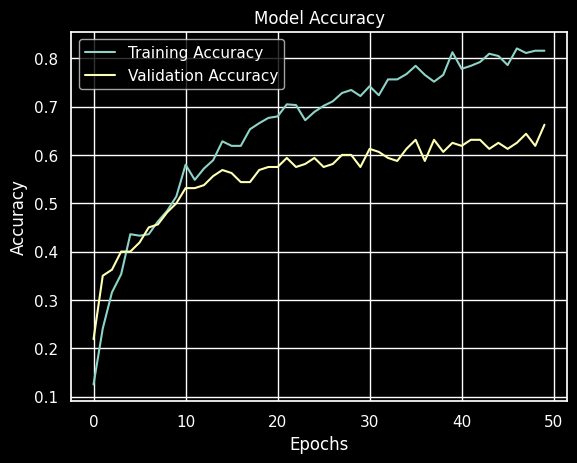

In [65]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Model Accuracy')
plt.show()

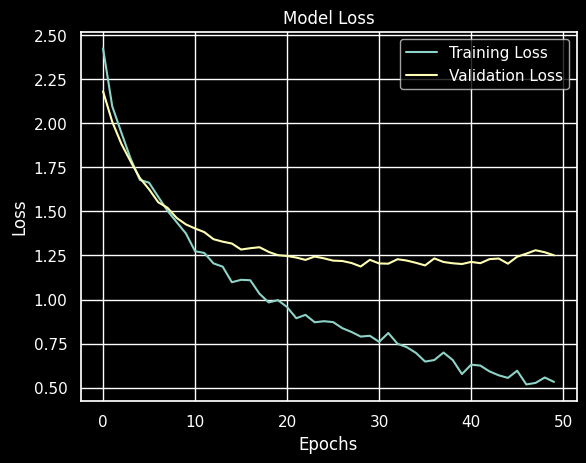

In [66]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Model Loss')
plt.show()